In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from collections import Counter
from scipy import stats
import seaborn as sns


np.set_printoptions(precision=3) 

# Adaptation of kNN Classifier for Regression

In the beginning of the lecture, we learned that classification is only one technique in supervised learning. Another one is regression. Here, we explore adapting the kNN classifier for regression.


**(a) Describe your strategy to adapt the kNN classifier from classification to regression**

To adapt the kNN classifier from classification to regression we decided to find $k$ neighbours of a sample as we did in classicication and, instead of returning the class that the number of neigbours presented the most, we return the mean on the dependent variable $y$ of the $k$ closest samples.


**(b) Implement your proposed method and cross-validation (own coding required for both!)**

Label: X, Shape: (300,)
Label: y, Shape: (300,)
NaN values in X:  0
NaN values in y:  0
Outlier indices in X:  (array([], dtype=int64),)
Mean of X:  12.38645228990477
Standard deviation of X:  7.040730832664398
Min of X:  0.06918112841850435
Max of X:  25.119124344057408
Mean of y:  -0.02699673229022231
Standard deviation of y:  0.7297741883679392
Min of y:  -1.412222853997566
Max of y:  1.2899674564482337


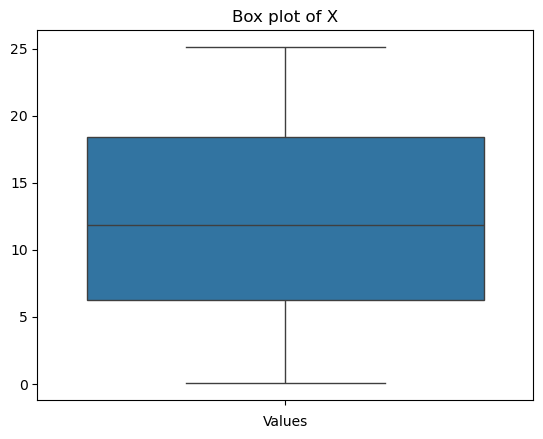

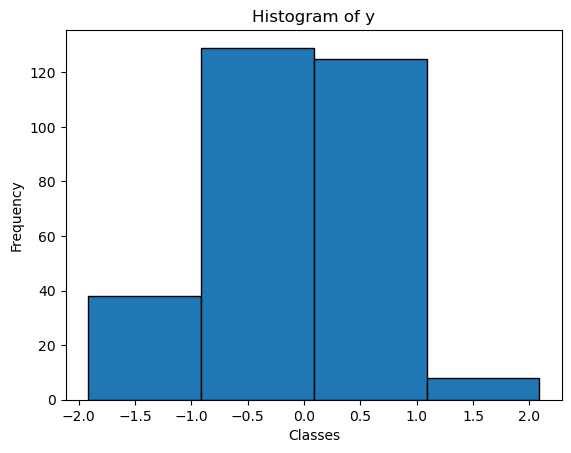

In [2]:
# Load the data
data = np.load('dataset_4.npz')

# Get the labels
keys = list(data.keys())

labels_and_shapes = {key: data[key].shape for key in keys}

for label, shape in labels_and_shapes.items():
    print(f"Label: {label}, Shape: {shape}")

X = data['X']
y = data['y']

# Check for NaN
print("NaN values in X: ", np.isnan(X).sum())
print("NaN values in y: ", np.isnan(y).sum())

# Check for outliers in X using Z-score
z_scores_X = np.abs(stats.zscore(X))
outliers_X = np.where(z_scores_X > 3)
print("Outlier indices in X: ", outliers_X)

# Basic statistical description
print("Mean of X: ", np.mean(X))
print("Standard deviation of X: ", np.std(X))
print("Min of X: ", np.min(X))
print("Max of X: ", np.max(X))
print("Mean of y: ", np.mean(y))
print("Standard deviation of y: ", np.std(y))
print("Min of y: ", np.min(y))
print("Max of y: ", np.max(y))

sns.boxplot(y=X)

plt.title('Box plot of X')
plt.xlabel('Values')
plt.show()


# Histogram of y
plt.hist(y, bins=np.arange(y.min(), y.max()+2) - 0.5, edgecolor='black')
plt.title('Histogram of y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
class CustomKNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = X.reshape(-1, 1)
        self.y = y

    def predict(self, X_test):
        X_test = X_test.reshape(-1, 1)
        predictions = []
        for x in X_test:
            distances = np.abs(self.X - x)
            indices = np.argsort(distances.flatten())[:self.k]
            k_nearest_y = self.y[indices]
            prediction = np.mean(k_nearest_y)
            predictions.append(prediction)
        return np.array(predictions)

In [4]:
knn_regressor = CustomKNNRegressor(k=3)
knn_regressor.fit(X_train, y_train)

# predicting
predictions = knn_regressor.predict(X_test)

In [5]:
class DummyRegressor:
    def __init__(self):
        self.prediction_value = None

    def fit(self, X, y):
        self.prediction_value = np.mean(y)

    def predict(self, X):
        return np.full(len(X), self.prediction_value)


def k_fold_cross_validation(X, y, f=5, use_dummy=False):
    fold_size = len(X) // f
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    mse_values = []

    for i in range(f):
        validation_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, X_val = X[train_indices], X[validation_indices]
        y_train, y_val = y[train_indices], y[validation_indices]

        if use_dummy:
            dummy_regressor = DummyRegressor()
            dummy_regressor.fit(X_train, y_train)
            predictions = dummy_regressor.predict(X_val)
        else:
            knn_regressor = CustomKNNRegressor(k=3)
            knn_regressor.fit(X_train, y_train)
            predictions = knn_regressor.predict(X_val)

        mse = np.mean((y_val - predictions) ** 2)
        mse_values.append(mse)

    mean_mse = np.mean(mse_values)
    print(f"Mean MSE: {mean_mse}")


**(c) Evaluate your models performance on dataset4 and compare to a dummy regressor (use cross validation)**

In [6]:
def evaluate_model_performance(X, y, k=5):
    print("Dummy Regressor (CV):")
    k_fold_cross_validation(X, y, k, use_dummy=True)
    
    print("Custom kNN Regressor (CV):")
    k_fold_cross_validation(X, y, k)

In [7]:
# comparison of models on dataset4
evaluate_model_performance(X, y)

Dummy Regressor (CV):
Mean MSE: 0.5410051079840791
Custom kNN Regressor (CV):
Mean MSE: 0.05607123692247031


We can infer that kNN for regression and a dummy regresor work both very bad and almost the same if we compare both the mean squared errors with cross validation.

**(d) Test how your model behaves for different values of $k$ in the range $[2, 100]$. Report the model’s performance for three values of $k$ where you observe:**

(i) **Good Generalization:** 

(ii) **Overfitting:** 

(iii) **Underfitting:** 

Max MSE: 0.6735559660249766, k: 89
Min MSE: 0.038944415276634836, k: 6
Median MSE: 0.43566426559469973, k: 51


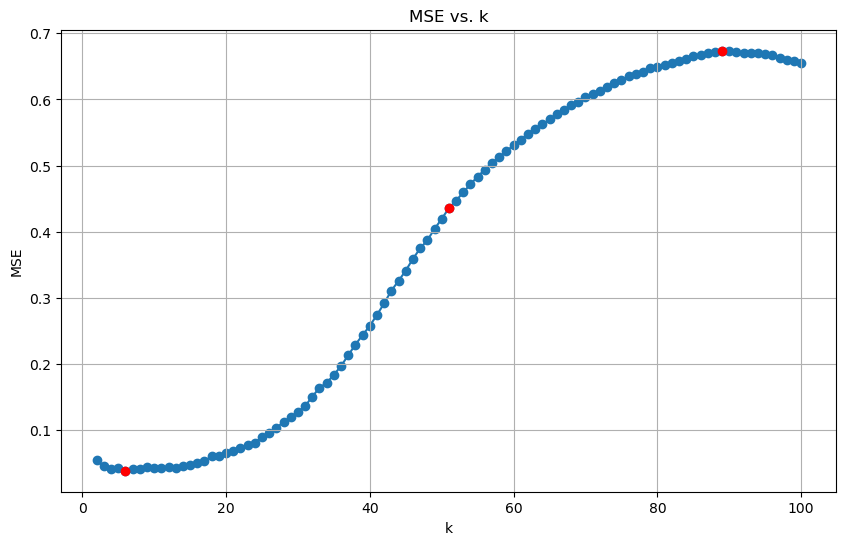

In [8]:
k_values = range(2, 101)
mse_values = []

for f in k_values:
    knn_regressor = CustomKNNRegressor(k=f)
    knn_regressor.fit(X_train, y_train)
    predictions = knn_regressor.predict(X_test)
    mse = np.mean((y_test - predictions) ** 2)
    mse_values.append(mse)

max_mse = max(mse_values)
min_mse = min(mse_values)
median_mse = np.median(mse_values)

k_max = k_values[mse_values.index(max_mse)]
k_min = k_values[mse_values.index(min_mse)]
k_median = k_values[mse_values.index(median_mse)]

print(f"Max MSE: {max_mse}, k: {k_max}")
print(f"Min MSE: {min_mse}, k: {k_min}")
print(f"Median MSE: {median_mse}, k: {k_median}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', linestyle='-', zorder=1)
plt.scatter([k_max, k_min, k_median], [max_mse, min_mse, median_mse], color='red', zorder=2) 
plt.title('MSE vs. k')
plt.xlabel('k')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


In [9]:
for mse, k in zip([max_mse, min_mse, median_mse], [k_max, k_min, k_median]):
    knn_regressor = CustomKNNRegressor(k=k)
    knn_regressor.fit(X_train, y_train)
    predictions = knn_regressor.predict(X_test)
    print(f"MSE: {mse}, k: {k}, Predictions: {predictions}")

MSE: 0.6735559660249766, k: 89, Predictions: [-0.044 -0.145  0.129 -0.145 -0.17   0.108  0.129  0.254 -0.145 -0.145
  0.129  0.038  0.108  0.129  0.136 -0.043  0.129  0.21   0.129  0.129
 -0.145  0.049  0.182 -0.149  0.161 -0.145  0.129 -0.142 -0.156  0.129
 -0.145  0.207  0.041  0.189 -0.077  0.13  -0.062 -0.03   0.038  0.129
  0.129  0.116 -0.088 -0.106 -0.145  0.092  0.129 -0.145  0.129  0.254
  0.055 -0.145  0.189  0.129  0.218 -0.178  0.094 -0.145  0.207 -0.134]
MSE: 0.038944415276634836, k: 6, Predictions: [ 0.038 -0.175 -0.91  -0.175  0.91  -0.853  0.861 -0.893  0.94  -0.815
 -0.286 -0.427 -0.808  0.123 -0.408  0.395  0.697 -0.89   0.844 -0.775
 -0.504 -0.427 -0.52   0.801 -0.711 -0.827 -0.614  0.758  0.922 -0.976
  1.03  -0.881  0.19  -0.721  0.657 -0.373  0.403  0.013 -0.427  0.924
 -0.148 -0.194  0.157  0.749 -1.064 -0.853  0.533 -0.095 -0.775 -0.877
 -0.236  0.191 -0.721  0.817 -0.881  0.846 -0.294  0.191 -0.881  0.753]
MSE: 0.43566426559469973, k: 51, Predictions: [ 0.074  

The minimum MSE represents the overfitting of the statistical method, the maximum MSE represents its underfitting. As we could forsee, for small values of $k$ we overfit, because we can not make predictions good enough for new samples, whereas  for big values of $k$ we underfit, because we are taking too many samples to make predictions, so they are inaccurate as soon as the dimension of the neighbourhood gets closer to the dimension of the dataset.
For the good generalization we take the mean MSE wich is the average for all $k$.

## Artificial data

We will first consider an artificial data set.

**(a) Train three different regression models: A linear, a polynomial regression model and kNN Regression. Evaluate them with cross-validation using R2-score on data set 5.**

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Label: X, Shape: (500, 2)
Label: y, Shape: (500,)
NaN values in X:  0
NaN values in y:  0
Outlier indices in X:  (array([ 45,  45, 129, 394, 441], dtype=int64), array([0, 1, 1, 1, 1], dtype=int64))
Mean of X:  0.022465756524055813
Standard deviation of X:  0.7009394917921009
Min of X:  -2.4238793266289567
Max of X:  3.852731490654721
Mean of y:  0.09107662721079873
Standard deviation of y:  16.37857748057804
Min of y:  -52.57573147465133
Max of y:  50.973285149706655


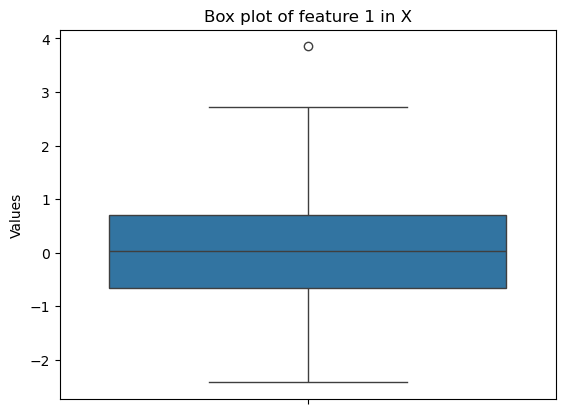

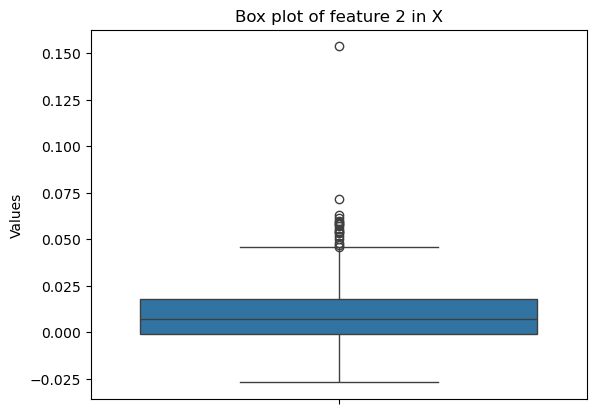

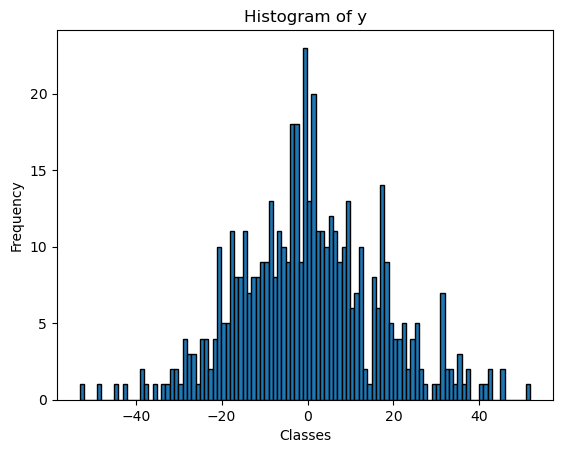

In [11]:
# Load the data
data = np.load('dataset_5.npz')

# Get the labels
keys = list(data.keys())

labels_and_shapes = {key: data[key].shape for key in keys}

for label, shape in labels_and_shapes.items():
    print(f"Label: {label}, Shape: {shape}")

X = data['X']
y = data['y']

# Check for NaN
print("NaN values in X: ", np.isnan(X).sum())
print("NaN values in y: ", np.isnan(y).sum())

# Check for outliers in X using Z-score
z_scores_X = np.abs(stats.zscore(X))
outliers_X = np.where(z_scores_X > 3)
print("Outlier indices in X: ", outliers_X)

# Basic statistical description
print("Mean of X: ", np.mean(X))
print("Standard deviation of X: ", np.std(X))
print("Min of X: ", np.min(X))
print("Max of X: ", np.max(X))
print("Mean of y: ", np.mean(y))
print("Standard deviation of y: ", np.std(y))
print("Min of y: ", np.min(y))
print("Max of y: ", np.max(y))

# Create horizontal box plots for each feature in X
for i in range(X.shape[1]):
    sns.boxplot(y=X[:, i])
    plt.title(f'Box plot of feature {i+1} in X')
    plt.ylabel('Values')
    plt.show()

# Histogram of y
plt.hist(y, bins=np.arange(y.min(), y.max()+2) - 0.5, edgecolor='black')
plt.title('Histogram of y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

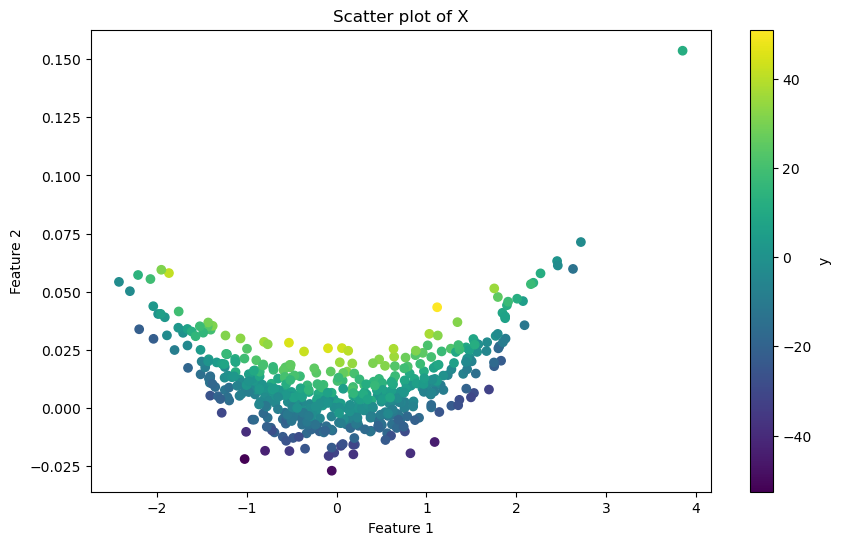

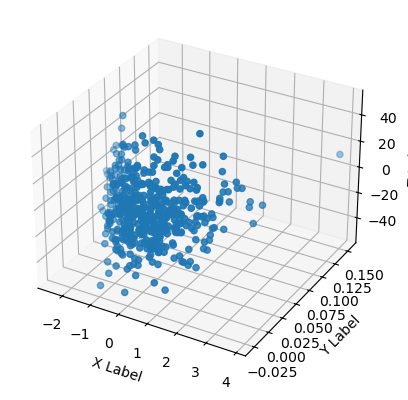

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Scatter plot of X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='y')
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assuming X is a 2D array and y is a 1D array
ax.scatter(X[:, 0], X[:, 1], y)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [13]:
#cross validation with 5 folds

# linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')

# polynomial regression for d = 2
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
poly_scores = cross_val_score(poly_model, X, y, cv=5, scoring='r2')

# kNN regression for k = 5
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='r2')

print("R2-score of linear regression: ", np.mean(linear_scores))
print("R2-score of polynomial regression for d = 2 : ", np.mean(poly_scores))
print("R2-score of kNN regression for k = 5: ", np.mean(knn_scores))


R2-score of linear regression:  0.3157003966906689
R2-score of polynomial regression for d = 2 :  0.9659559294838468
R2-score of kNN regression for k = 5:  0.12316899603683236


As we can see kNN regression with $k=5$ returns the lowest value for the $R^2$, it is very close to $0$ where $0$ reflects the fact that the model predicts at worse.

For linear regressione the value of the $R^2$ is still small, sign that also this method doesn't make good predictions.

At the end for polynomial regression with degree $2$ we get the biggest value for the $R^2$, this means that polynomial regression works very good. In fact, the value is close to $1$.

By the way, what we should underline is the fact that we did not tune the parameters of the degree of polynomial regression and the number of neighbours of kNN.

**(b) Apply standardization to data set 5 and rerun all experiments.**

In [14]:
# standardization of the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

#cross validation with 5 folds

# linear regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_scores = cross_val_score(linear_model, X_scaled, y, cv=5, scoring='r2')

# polynomial regression
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_scaled, y_train)
poly_scores = cross_val_score(poly_model, X_scaled, y, cv=5, scoring='r2')

# kNN regression
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_scores = cross_val_score(knn_model, X_scaled, y, cv=5, scoring='r2')

print("R2-score of linear regresion: ", np.mean(linear_scores))
print("R2-score of polynomial regression for d = 2 : ", np.mean(poly_scores))
print("R2-score of kNN regression for k = 5: ", np.mean(knn_scores))

R2-score of linear regresion:  0.31570039669066885
R2-score of polynomial regression for d = 2 :  0.9659559294838471
R2-score of kNN regression for k = 5:  0.8835767551646697


Now kNN regression with $k=5$ (wich previoulsy returned the lowest value for the $R^2$) provides a very high value for the $R^2$. Probably this is due to the fact that the data need to be comparable before applying a statistical method.

For linear regressione the value of the $R^2$ remains still small, so even if we standardize the data we don't get good results.

For polynomial regression with degree $2$, we get the biggest value for the $R^2$ and if we confront the standardize data with the ones non standardized, the $R^2$ remains exactly the same. This may be because the two independent variables and the dependent variable have a quadratic proportion.

By the way, what we underline that we did not tune the parameters of the degree of polynomial regression and the number of neighbours of kNN.

**(c) (own coding required!) Implement a function for computing and plotting the so-called learning curve (see description below). Compare the learning curves of the different models. Compute the learning curve with R2 for 1 to n samples for linear regression and for k to n for kNN regression. In this task, a simple train test split is sufficient, you do not need to do cross validation here.**

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

def compute_learning_curve(X_train, y_train, X_test, y_test):
    train_sizes = range(2, len(X_train) + 1)
    train_scores = []
    train_scores_knn = []
    train_scores_poly = []
    test_scores = []
    test_scores_knn = []
    test_scores_poly = []

    for train_size in train_sizes:
        # Train the models
        linear_model = LinearRegression()
        linear_model.fit(X_train[:train_size], y_train[:train_size])
        
        # Ensure n_neighbors is not greater than train_size
        knn_model = KNeighborsRegressor(n_neighbors=min(5, train_size))
        knn_model.fit(X_train[:train_size], y_train[:train_size])

        # Compute R2 scores
        train_score = linear_model.score(X_train[:train_size], y_train[:train_size])
        test_score = linear_model.score(X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

        train_score_knn = knn_model.score(X_train[:train_size], y_train[:train_size])
        test_score_knn = knn_model.score(X_test, y_test)
        train_scores_knn.append(train_score_knn)
        test_scores_knn.append(test_score_knn)

        # Train the model with polynomial features
        poly_features = PolynomialFeatures(degree=2)
        X_train_poly = poly_features.fit_transform(X_train[:train_size])
        X_test_poly = poly_features.transform(X_test)

        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train[:train_size])

        train_score_poly = poly_model.score(X_train_poly, y_train[:train_size])
        test_score_poly = poly_model.score(X_test_poly, y_test)
        train_scores_poly.append(train_score_poly)
        test_scores_poly.append(test_score_poly)

    # Create subplots
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the learning curves
    axs[0].plot(train_sizes, train_scores, label='Train')
    axs[0].plot(train_sizes, test_scores, label='Test')
    axs[0].set_title('Linear Regression')
    axs[0].set_xlabel('Number of training samples')
    axs[0].set_ylabel('$R^2$ score')
    axs[0].legend()

    axs[1].plot(train_sizes, train_scores_knn, label='Train')
    axs[1].plot(train_sizes, test_scores_knn, label='Test')
    axs[1].set_title('kNN Regression')
    axs[1].set_xlabel('Number of training samples')
    axs[1].set_ylabel('$R^2$ score')
    axs[1].legend()

    axs[2].plot(train_sizes, train_scores_poly, label='Train')
    axs[2].plot(train_sizes, test_scores_poly, label='Test')
    axs[2].set_title('Polynomial Regression')
    axs[2].set_xlabel('Number of training samples')
    axs[2].set_ylabel('$R^2$ score')
    axs[2].legend()

    plt.tight_layout()
    plt.show()


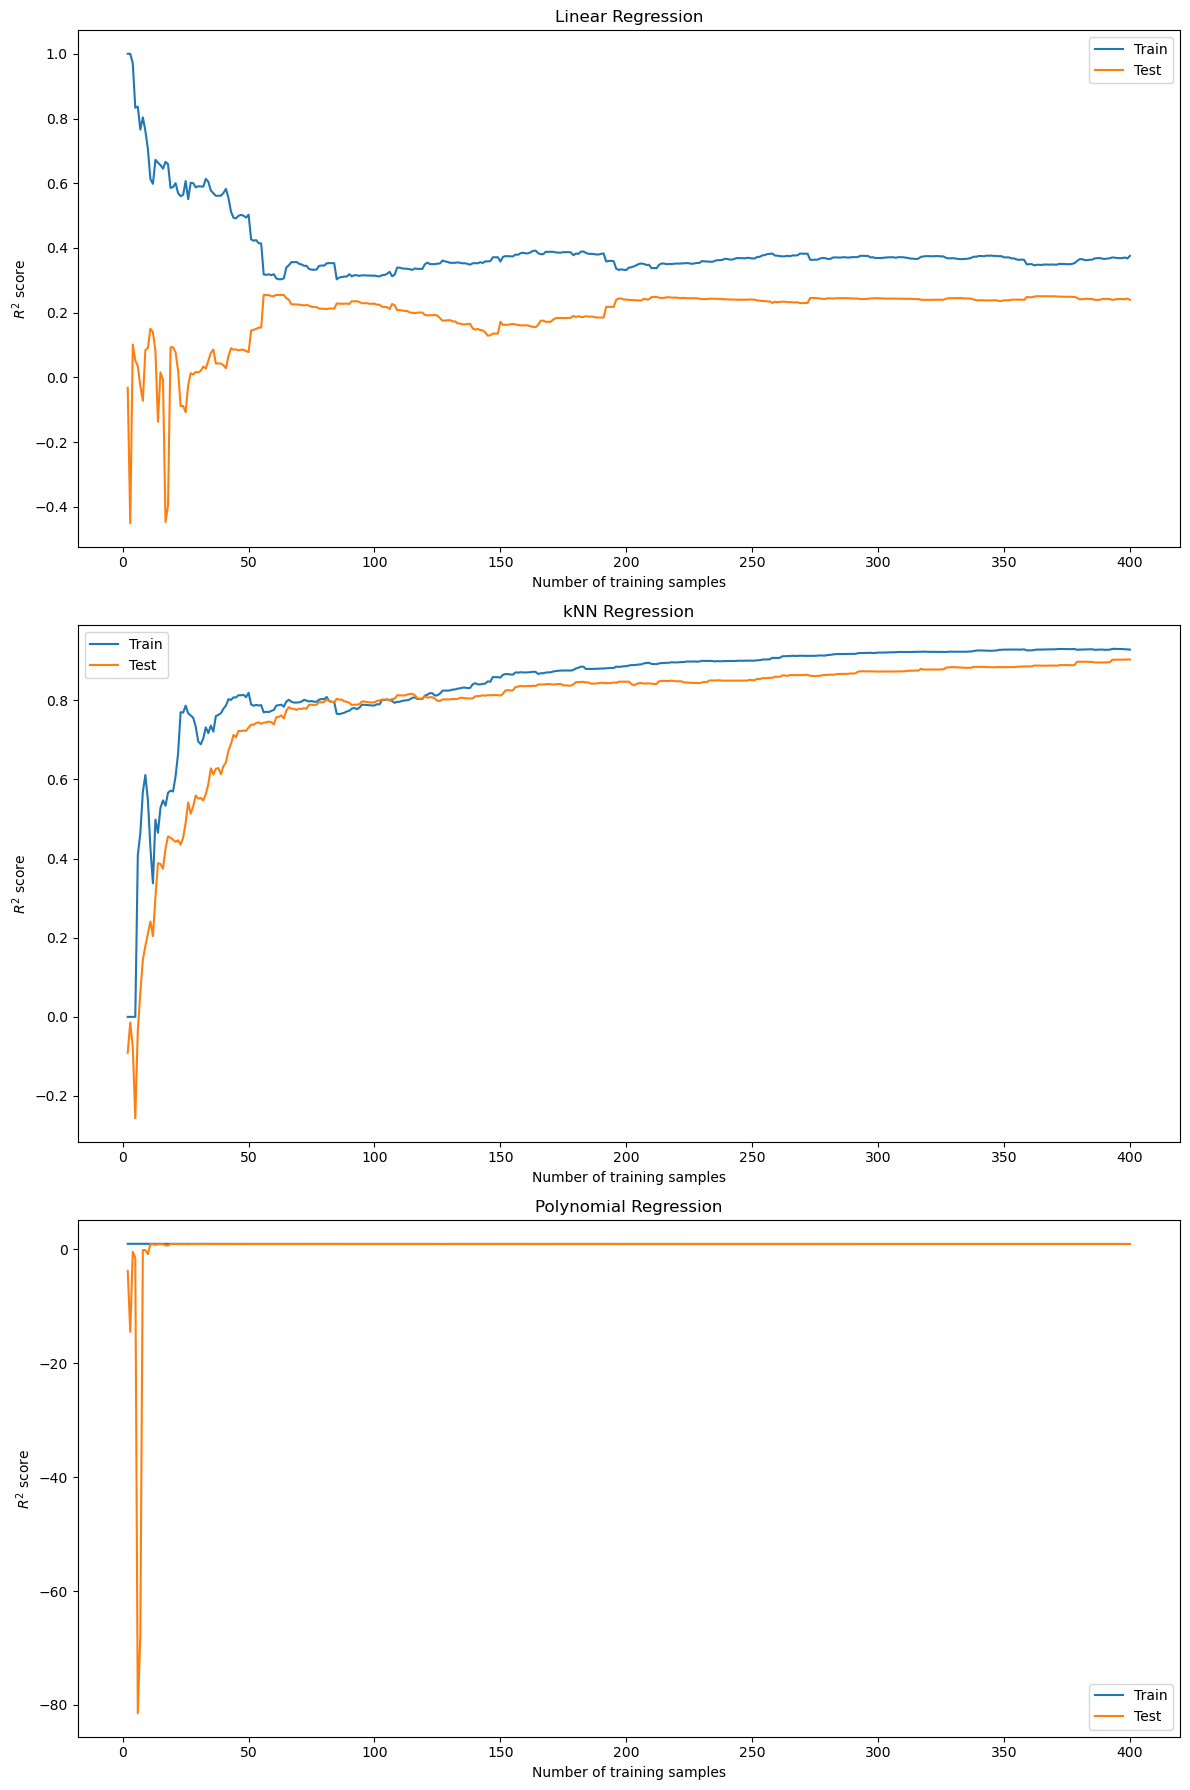

In [16]:
compute_learning_curve(X_train_scaled, y_train, X_test_scaled, y_test)

### 3 Real world data

Now, we move on to real world data. More precisely, a data set about house prices is given. Load the data `real_world.npz` with the field names `X`, `y`, and `features`. `X` gives you the data matrix, `y` the corresponding outputs. You can find the feature names in `features`.

**(a) As for the artificial data, train **Linear** and **kNN Regression** and evaluate them with the **R2-score** using cross-validation.**

Label: X, Shape: (1095, 10)
Label: y, Shape: (1095,)
Label: features, Shape: (10,)
NaN values in X:  0
NaN values in y:  0
Outlier indices in X:  (array([  17,   31,   33,   59,   59,   69,   72,   72,   75,   75,  111,
        114,  121,  146,  146,  146,  152,  152,  161,  172,  188,  221,
        222,  238,  239,  242,  258,  259,  272,  282,  288,  296,  297,
        302,  316,  325,  334,  334,  360,  369,  369,  369,  402,  407,
        411,  415,  432,  432,  432,  432,  437,  441,  443,  454,  458,
        458,  466,  473,  474,  481,  482,  485,  491,  496,  500,  506,
        506,  518,  522,  522,  522,  522,  530,  532,  536,  551,  553,
        553,  553,  553,  557,  575,  578,  591,  624,  625,  625,  641,
        644,  645,  645,  646,  654,  669,  702,  729,  736,  736,  741,
        743,  743,  745,  747,  756,  768,  783,  827,  838,  842,  875,
        882,  882,  887,  887,  895,  907,  917,  920,  932,  938,  952,
        960,  961,  973,  992,  996, 1009, 1011, 1

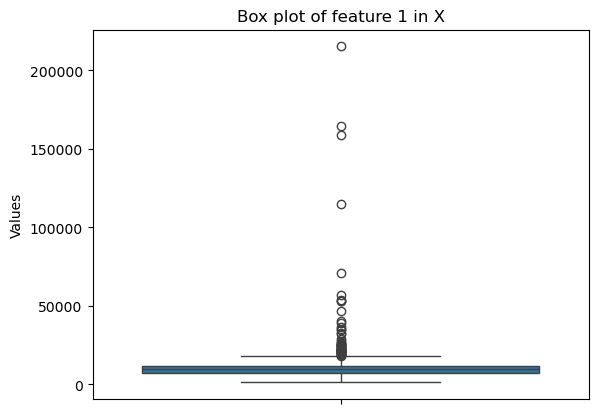

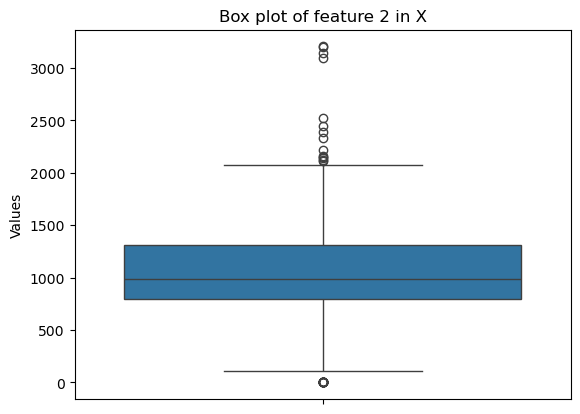

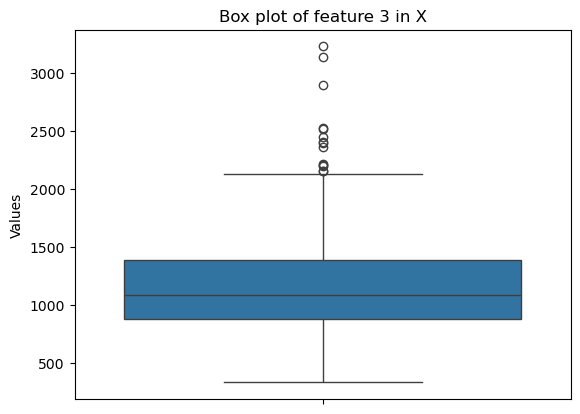

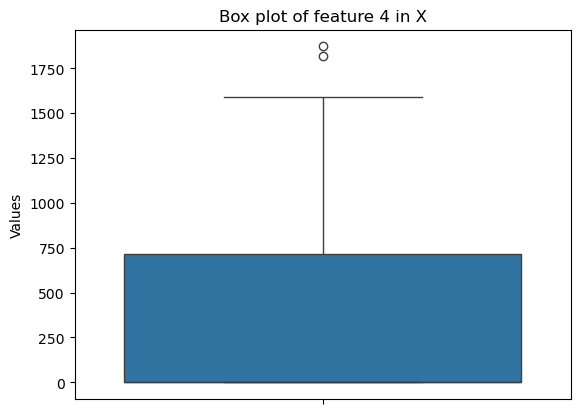

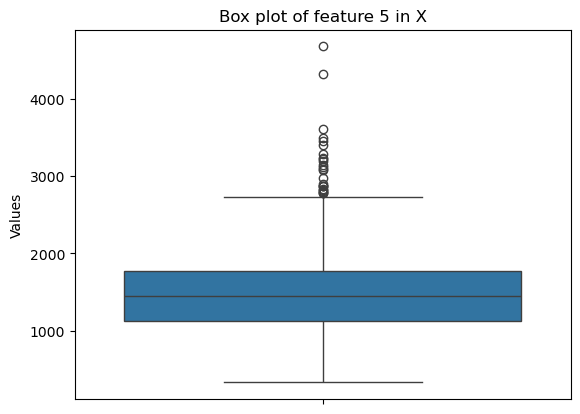

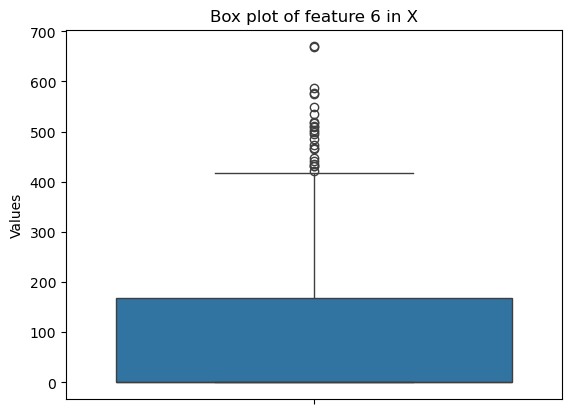

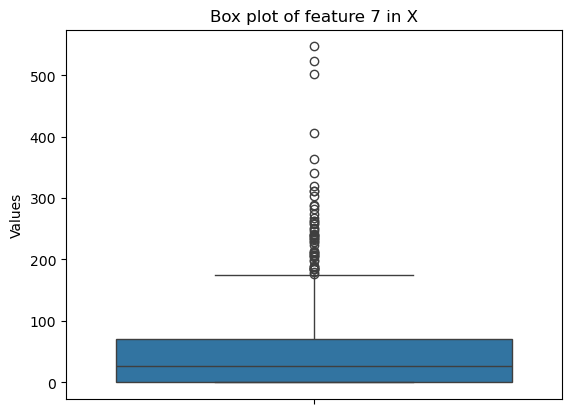

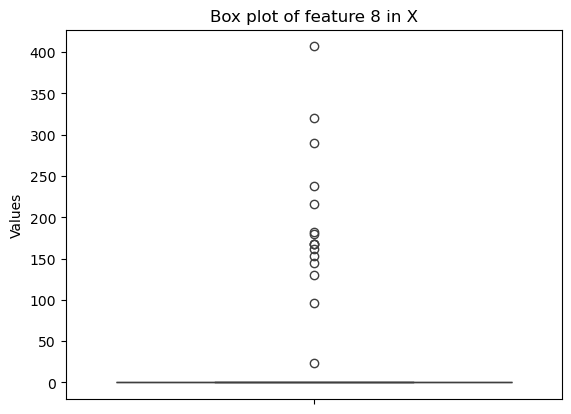

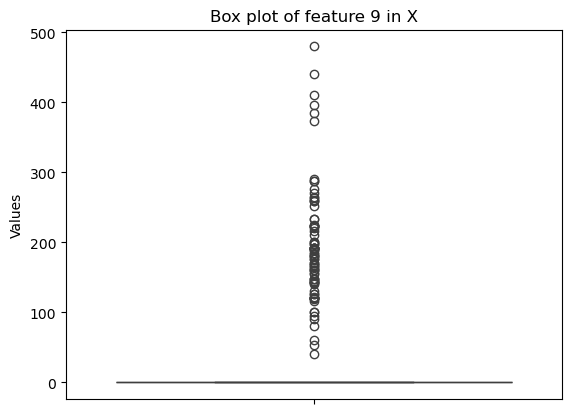

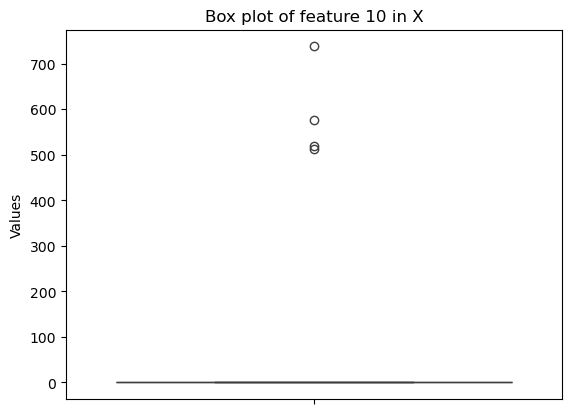

In [17]:
# Load the data
data = np.load('real_world.npz')

# Get the labels
keys = list(data.keys())

labels_and_shapes = {key: data[key].shape for key in keys}

for label, shape in labels_and_shapes.items():
    print(f"Label: {label}, Shape: {shape}")

X = data['X']
y = data['y']
features = data['features']

# Check for NaN
print("NaN values in X: ", np.isnan(X).sum())
print("NaN values in y: ", np.isnan(y).sum())

# Check for outliers in X using Z-score
z_scores_X = np.abs(stats.zscore(X))
outliers_X = np.where(z_scores_X > 3)
print("Outlier indices in X: ", outliers_X)

# Basic statistical description
print("Mean of X: ", np.mean(X))
print("Standard deviation of X: ", np.std(X))
print("Min of X: ", np.min(X))
print("Max of X: ", np.max(X))

# Create horizontal box plots for each feature in X
for i in range(X.shape[1]):
    sns.boxplot(y=X[:, i])
    plt.title(f'Box plot of feature {i+1} in X')
    plt.ylabel('Values')
    plt.show()

# Histogram of y
# plt.hist(y, bins=np.arange(y.min(), y.max()+2) - 0.5, edgecolor='black')
# plt.title('Histogram of y')
# plt.xlabel('Classes')
# plt.ylabel('Frequency')
# plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Train Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train kNN Regression
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Evaluate models with R2-score using cross-validation
linear_cv_scores = cross_val_score(linear_model, X_test, y_test, cv=5, scoring='r2')
knn_cv_scores = cross_val_score(knn_model, X_test, y_test, cv=5, scoring='r2')

print(f"Linear regression CV R2-score: {linear_cv_scores.mean()}")
print(f"kNN regression CV R2-score: {knn_cv_scores.mean()}")


Linear regression CV R2-score: 0.5551191263933013
kNN regression CV R2-score: 0.37549323887841607


**(b) Compare and analyze the results. Additionally consider the learning curves of your models, describe and analyze them. You do not need to use cross validation.**

**Hint: here it might make sense to not add one sample after another but to compute the learning curve in bigger step sizes - for example one of 10.**

In [19]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    # plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    #                      train_scores_mean + train_scores_std, alpha=0.1,
    #                      color="r")
    # plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    #                      test_scores_mean + test_scores_std, alpha=0.1,
                        #  color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\schin\\miniconda3\\envs\\introml\\lib\\site-packages\\matplotlib\\pyplot.py'>

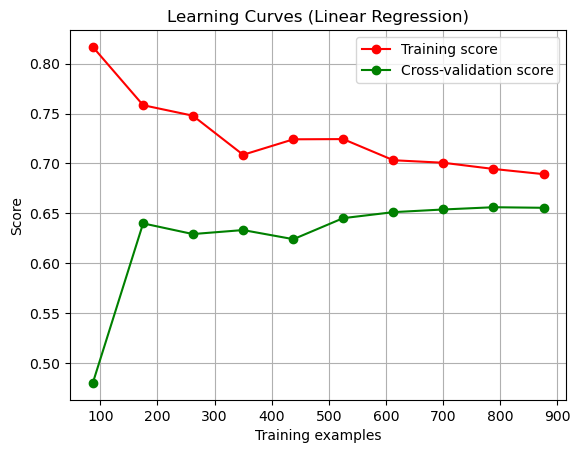

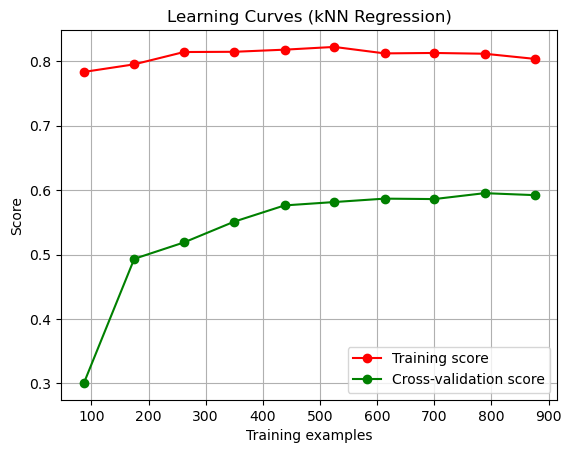

In [20]:
# Plot learning curves for Linear Regression
plot_learning_curve(LinearRegression(), "Learning Curves (Linear Regression)", X, y)

# Plot learning curves for kNN Regression
plot_learning_curve(KNeighborsRegressor(n_neighbors=3), "Learning Curves (kNN Regression)", X, y)

**(c) In this task we consider additional data from `new_data.npz` (same fields `X`, `y`, `features`), where some values are missing. Implement two approaches to impute missing values:** 
1. Set the missing value as the feature mean,
2. Derive the missing value from the neighbor samples.

Train **Linear** and **kNN Regression** on `real_world.npz` and evaluate their performance on the new data with each approach. Explain which approach works better and why.

Label: X, Shape: (365, 10)
Label: y, Shape: (365,)
Label: features, Shape: (10,)
NaN values in X:  100
NaN values in y:  0


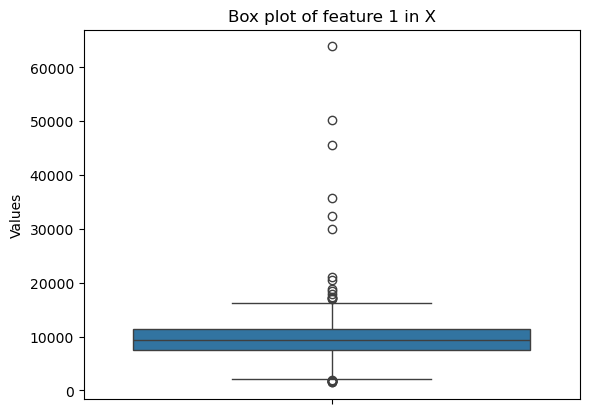

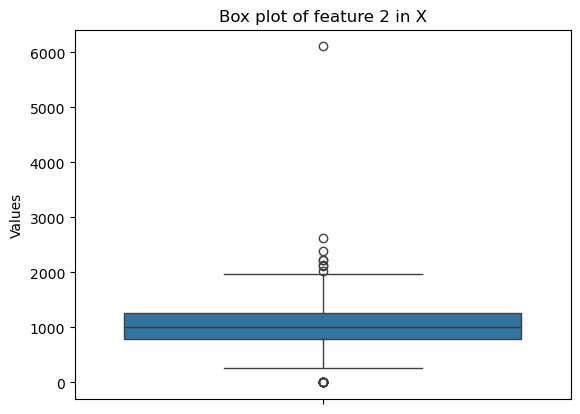

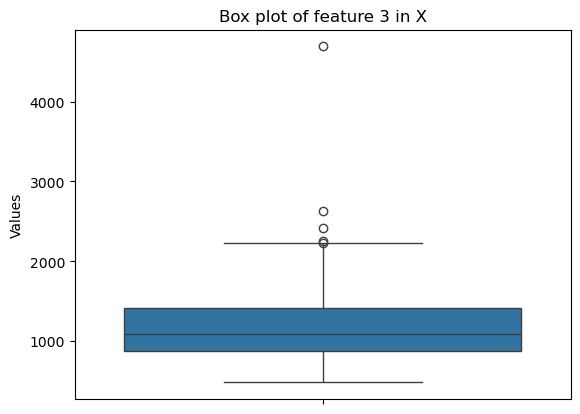

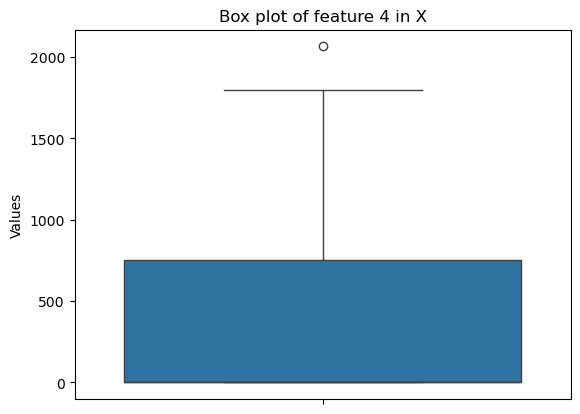

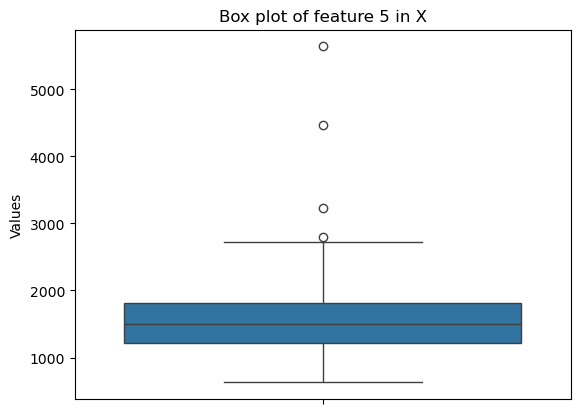

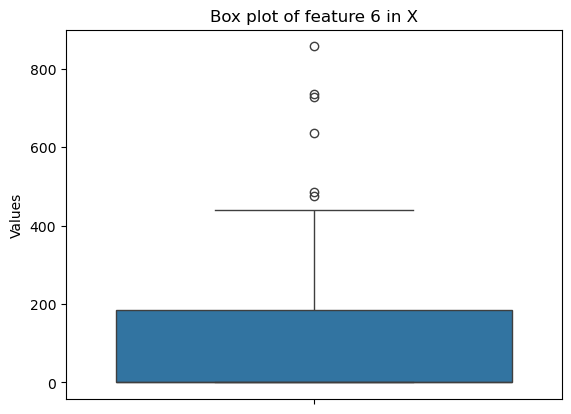

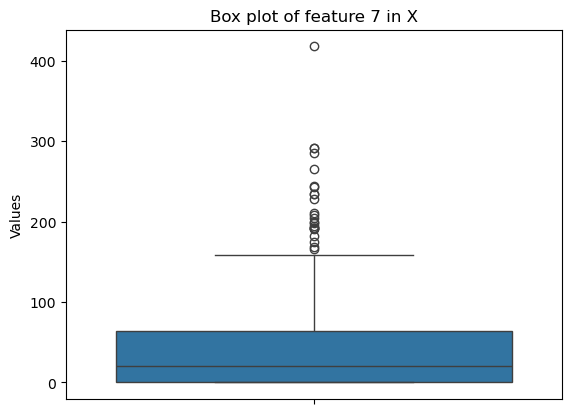

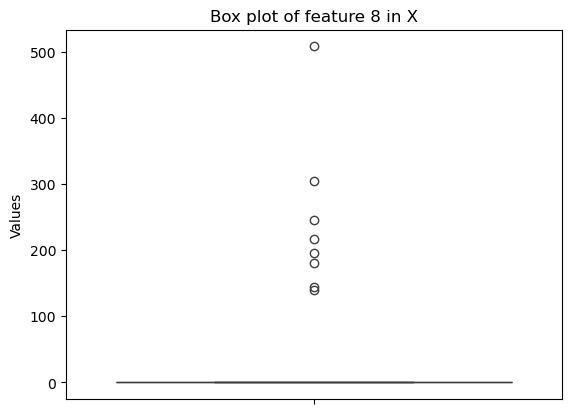

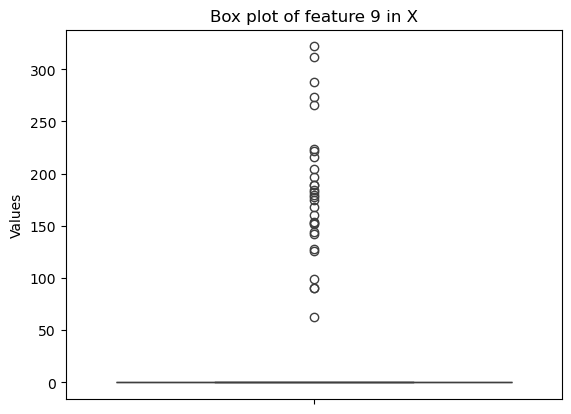

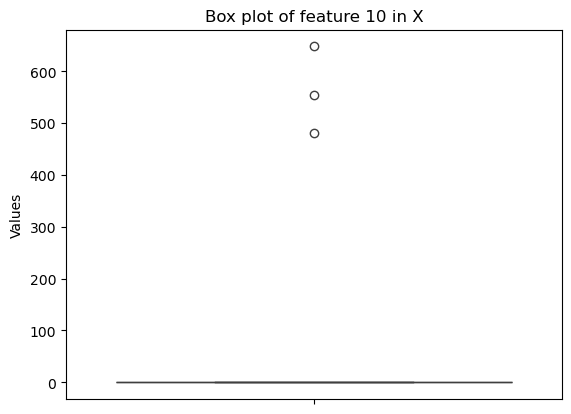

In [21]:
# Load the data
data_real_world = np.load('new_data.npz')

# Get the labels
keys = list(data_real_world.keys())

labels_and_shapes = {key: data_real_world[key].shape for key in keys}

for label, shape in labels_and_shapes.items():
    print(f"Label: {label}, Shape: {shape}")

X = data_real_world['X']
y = data_real_world['y']

# Check for NaN
print("NaN values in X: ", np.isnan(X).sum())
print("NaN values in y: ", np.isnan(y).sum())

# Create horizontal box plots for each feature in X
for i in range(X.shape[1]):
    sns.boxplot(y=X[:, i])
    plt.title(f'Box plot of feature {i+1} in X')
    plt.ylabel('Values')
    plt.show()



In [22]:
from sklearn.metrics import r2_score

# Approach 1: Set the missing value as the feature mean
X1 = X.copy()
for i in range(X.shape[1]):
    nan_indices = np.where(np.isnan(X[:, i]))[0]
    mean_val = np.nanmean(X[:, i])
    X1[nan_indices, i] = mean_val

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=0)
# Train Linear and kNN Regression on real_world.npz
linear_model_real_world = LinearRegression().fit(X_train, y_train)
knn_model_real_world = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Evaluate performance on new data
y_pred_linear1 = linear_model_real_world.predict(X_test)
y_pred_knn1 = knn_model_real_world.predict(X_test)
r2_score_linear1 = r2_score(y_test, y_pred_linear1)
r2_score_knn1 = r2_score(y_test, y_pred_knn1)

print(f"Linear Regression R2-score with mean imputation: {r2_score_linear1}")
print(f"kNN Regression R2-score with mean imputation: {r2_score_knn1}")


Linear Regression R2-score with mean imputation: 0.5998231908260756
kNN Regression R2-score with mean imputation: 0.24925203579752364


In [23]:

# Approach 2: Derive the missing value from the neighbor samples
X2 = X.copy()
for i in range(X.shape[1]):
    nan_indices = np.where(np.isnan(X[:, i]))[0]
    for j in nan_indices:
        if j == 0:
            X2[j, i] = X[j+1, i] if not np.isnan(X[j+1, i]) else 0  # or np.nanmean(X[:, i])
        elif j == X.shape[0]-1:
            X2[j, i] = X[j-1, i] if not np.isnan(X[j-1, i]) else 0  # or np.nanmean(X[:, i])
        else:
            if np.isnan(X[j-1, i]) and np.isnan(X[j+1, i]):
                X2[j, i] = 0  # or np.nanmean(X[:, i])
            else:
                X2[j, i] = np.nanmean([X[j-1, i], X[j+1, i]])


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=0)
# Train Linear and kNN Regression on real_world.npz
linear_model_real_world = LinearRegression().fit(X_train, y_train)
knn_model_real_world = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Evaluate performance on new data
y_pred_linear2 = linear_model_real_world.predict(X_test)
y_pred_knn2 = knn_model_real_world.predict(X_test)
r2_score_linear2 = r2_score(y_test, y_pred_linear2)
r2_score_knn2 = r2_score(y_test, y_pred_knn2)

print(f"Linear Regression R2-score with neighbor imputation: {r2_score_linear2}")
print(f"kNN Regression R2-score with neighbor imputation: {r2_score_knn2}")

Linear Regression R2-score with neighbor imputation: 0.5923455293628869
kNN Regression R2-score with neighbor imputation: 0.2332091787396886


As for which approach works better, it depends on the specific characteristics of the data. If the missing values are randomly distributed and there is no significant correlation between adjacent samples, then setting the missing value as the feature mean might work better. On the other hand, if there is a strong correlation between adjacent samples, then deriving the missing value from the neighbor samples might work better. However, without further information about the data, it’s hard to definitively say which approach is superior. It’s always a good idea to try different approaches and choose the one that gives the best performance on your validation set. Please note that this code does not handle the case where all values of a feature are missing. In such a case, you might need to drop the feature or fill in the missing values with a constant value. Also, the neighbor imputation method used here is very simple and only considers immediate neighbors. More sophisticated methods might give better results.